In [1]:
from pynq import Overlay
from pynq import allocate
import xrfclk
import numpy as np
import matplotlib.pyplot as plt
import time
from axitimer import AxiTimerDriver
from scipy import signal

In [2]:
ol = Overlay("hw/top.bit", download=True)

In [3]:
dma_recv = ol.axi_dma_0.recvchannel
capture_trig = ol.axi_gpio_capture.channel1[0]
pinc = ol.axi_gpio_pinc.channel1
cos_scale = ol.axi_gpio_scale.channel1
timer = ol.axi_timer_0
xrfclk.set_ref_clks(lmk_freq=122.88, lmx_freq=409.6)
f_samp = 4.096e9 # Hz
phase_bits = 24
timer.start_tmr()

In [4]:
def f_to_pinc(freq):
    return int((freq/f_samp)*(2**phase_bits))

In [5]:
frame_size = 32*65536
buffer = allocate(shape=(frame_size,), dtype=np.int16)

In [29]:
pinc.write(f_to_pinc(700e6),0xffffff)
cos_scale.write(0, 0xf)

transferred 4.0MiB in 0.51ms (4.089GS/s)


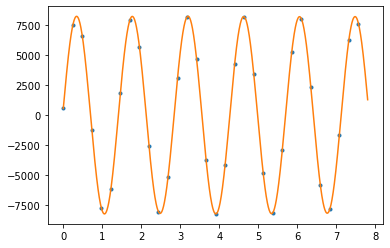

In [31]:
capture_trig.on()
capture_trig.off()
t1 = timer.read_count()
dma_recv.transfer(buffer)
t2 = timer.read_count()
N_samp = 32
OSR = 32
tvec = np.linspace(0,N_samp/f_samp*1e9,N_samp,endpoint=False)
tvec_osr = np.linspace(0,N_samp/f_samp*1e9,N_samp*OSR,endpoint=False)
plt.plot(tvec,buffer[N_samp:2*N_samp], '.')
plt.plot(tvec_osr,signal.resample_poly(np.array(buffer[:8*N_samp],dtype=np.float32),OSR,1)[N_samp*OSR:2*N_samp*OSR], '-')
dt = timer.time_it(t1, t2)
print(f"transferred {round(frame_size*2/(2**20), 3)}MiB in {round(dt*1e3,2)}ms ({round(frame_size/(1e9)/dt, 3)}GS/s)")

Text(0.5, 0, 'freq [GHz]')

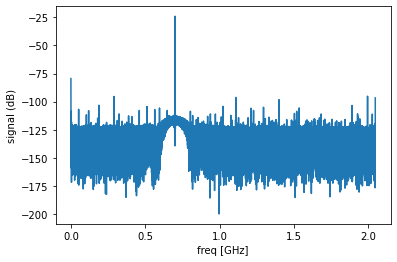

In [32]:
fft = 20*np.log10(abs(np.fft.rfft(buffer)))
fft -= 20*np.log10(32*65536*2**16)
plt.plot(np.linspace(0,0.5*4.096,fft.shape[0]),fft)
plt.ylabel("signal (dB)")
plt.xlabel("freq [GHz]")

In [19]:
# check IP version
print(f'{ol.rf_data_converter.read(0):#010x}')

0x02060300


In [18]:
# check tile current state (power on state machine), should be 0xf
print(f'{ol.rf_data_converter.read(0x1400c):#03x}')

0xf


In [17]:
# check tile reset count, should be 0 (resets to zero after read)
# seems like there's an issue that causes the ADC to reset on or shortly after startup, but after that it's fine
print(f'{ol.rf_data_converter.read(0x14038):#03x}')

0x0


In [15]:
# read converter 0 interrupt register
# bit 0-1: reserved
# bit 2: over-voltage
# bit 3: over-range
print(f'{ol.rf_data_converter.read(0x14208):#010x}')

0x00000000
